# **Learning gestures from 1 example**
## A pytorch implementation
### ___Pedro F da Costa___



# Setting up the Environment
To set the environment click on the play button (▶) on the left of the texts below. 

You need to allow GPU access to run the models (Runtime -> Change Runtime type -> Hard accelerator -> Choose **GPU**)

In [1]:
#@markdown Downloads trained models to test on gestures
%%capture
%%shell
# download trained segmentation model
wget -O model_segmentation.torch https://www.dropbox.com/s/khzgkh2761lsa84/model_segmentation.torch?dl=1
# download trained autoencoder
wget -O model_ae.torch https://www.dropbox.com/s/sjsa0u95n1fzd0b/model_ae.torch?dl=1
# download latents previously obtained to fit PCA
wget -O latent_list.npy https://www.dropbox.com/s/3dtfwwa4mvvarzn/latent_list.npy?dl=1
# download pytorch tools
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
#Move tools to root folder
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../
cd ../

In [7]:
#@markdown Installs dependencies
%%capture
from sklearn.decomposition import PCA
import numpy as np
import IPython.display as idisplay
from google.colab.output import eval_js
from IPython.display import display, Javascript, HTML, clear_output
from ipywidgets import widgets, Layout
from base64 import b64decode
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from engine import train_one_epoch, evaluate
import utils


# Running the proof-of-concept
My objective with this work is to create a low-dimensional manifold of possible gestures so that only one example of the gesture can allow to identify other examples of the same gesture. 

An image is a very high dimensional point in space as it contains hundreds of thousands of values. In order to build an effective manifold, we need to greatly reduce the number of working dimensions. I do so by using a segmentation model - Mask R CNN that learns to identify hands and binary masks from images. We train it using the [EgoHands dataset](http://vision.soic.indiana.edu/projects/egohands/).

Try it out below. You will be prompted to use the webcam. This is to run the model and no data ever leaves your computer.

<img src="https://raw.githubusercontent.com/PedroFerreiradaCosta/GestureLearner/main/figures/mask_rcnn.png" alt="FaceFitOpt Logo" width="800">

MaskRCNN architecure


In [8]:
#@markdown **Play me to try it out!**

# Instantiate class Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 5, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 5, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(3, 3)

        self.linear1 = nn.Linear(44556, 100)
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.linear2 = nn.Linear(100, 230400)
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation - torch.Size([1, 4, 180, 320])
        x = x.view(-1)
        x_out = F.relu(self.linear1(x))

        ## decode ##        
        x = F.relu(self.linear2(x_out))
        x = x.view(1,4,180,320)
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x, x_out

# Define device and load models
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_segmentation = torch.load('model_segmentation.torch')
model_segmentation = torch.nn.DataParallel(model_segmentation).to(device)
model_ae = torch.load('model_ae.torch')
model_ae = torch.nn.DataParallel(model_ae).to(device)
latent_list = np.load('latent_list.npy', allow_pickle=True)
pca = PCA(n_components=0.3, svd_solver='full').fit(latent_list)

# Javascript code for taking picture 
# This code is adapted from https://gist.github.com/korakot/d1573057a48eac8c13bdd3d3c4171c84
VIDEO_JS = idisplay.Javascript('''
async function takePhoto(quality) {
  // Create a video and play it.
  const video = document.createElement('video')
  document.body.appendChild(video)
  video.srcObject = await navigator.mediaDevices.getUserMedia({video: true})
  await video.play()
  // Resize the output to fit the video element.
  google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true)
  // Wait for video to be clicked.
  await new Promise((resolve) => video.onclick = resolve)
  const canvas = document.createElement('canvas')
  canvas.width = video.videoWidth
  canvas.height = video.videoHeight
  canvas.getContext('2d').drawImage(video, 0, 0)
  video.srcObject.getVideoTracks()[0].stop()
  video.remove()
  return canvas.toDataURL('image/jpeg', quality)
}
''')

# Python wrapper function to use the javascript code and save picture
def take_photo(filename='photo.jpg', quality=0.8): 
  display(VIDEO_JS)
  print("")
  print("Do a gesture to the camera and take the picture!")
  print("Take the picture by clicking on the image.")
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Let's go!
run = widgets.ToggleButton(
    value=False,
    description="Let's Go!",
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click when ready to start game.',
    layout= Layout(border = '1px solid black')
)

# Slider to adjust mask transparency
slider = widgets.FloatSlider(
          value=0.5,
          min=0,
          max=1,
          step=0.01,
          description='Mask %:',
          disabled=False,
          continuous_update=False,
          orientation='horizontal',
          readout=True,
          readout_format='.1f',)

redo = widgets.ToggleButton(
    value=False,
    description="Take a new photo!",
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click if you want a new photo.',
    layout= Layout(border = '1px solid black')
)

end = widgets.ToggleButton(
    value=False,
    description="End demo",
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to finish game.',
    layout= Layout(border = '1px solid black')
)
display(run)

def run_clicked(obj):
    display(HTML("<marquee style='width: 30%; color: green;'><b>&lt;&lt;&lt; Wait for camera &lt;&lt;&lt;</b></marquee>"))
    run.close()
    main()
    
run.observe(run_clicked, 'value')

def main():

    filename = take_photo()

    img = Image.open(filename).convert("RGB")

    img_torch = torch.as_tensor(np.array(img), dtype=torch.float32).permute(2,0,1) / 255

    model_segmentation.eval()
    with torch.no_grad():
        segmentation = model_segmentation([img_torch.to(device)])

    # Collapse all masks
    mask = torch.sum(segmentation[0]['masks'][:, 0], dim=0).clip(0,1)
    mask = mask.mul(255).byte().cpu().numpy()
    display(slider)
    def show_images(*args):
      clear_output()
      fig, ax = plt.subplots()
      ax.imshow(np.array(img), alpha=1-slider.value)
      ax.imshow(mask, alpha=slider.value)
      ax.set_axis_off()
      plt.show()
      display(slider)
      display(redo)
      display(end)

    def end_demo(*args):
      clear_output()

    def redo_demo(*args):
      clear_output()
      main()

    slider.observe(show_images, 'value')
    redo.observe(redo_demo, 'value')
    end.observe(end_demo, 'value')


To distill the information further and to learn the gesture manifold, we train a convolutional autoencoder that reduces the original mask to 100 values and then tries to reconstruct the mask from these values. This process forces the model to maintain in a lower dimension, all relevant information for these gestures

<img src="https://raw.githubusercontent.com/PedroFerreiradaCosta/GestureLearner/main/figures/autoencoder.png" alt="FaceFitOpt Logo" width="600">

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(-0.5, 1279.5, 719.5, -0.5)

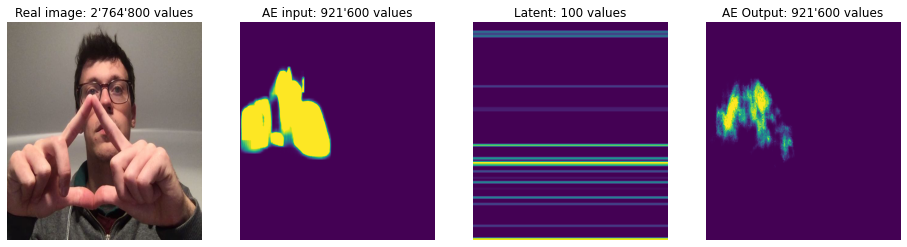

In [30]:
#@markdown **Autoencoder as a means to distill information. Play it!**
img = Image.open('photo.jpg').convert("RGB")

img_torch = torch.as_tensor(np.array(img), dtype=torch.float32).permute(2,0,1) / 255

model_segmentation.eval()
with torch.no_grad():
    segmentation = model_segmentation([img_torch.to(device)])

# Collapse all masks
mask = torch.sum(segmentation[0]['masks'][:, 0], dim=0).clip(0,1)

# Reshape to size use for autoencoder training
ae_input_raw = mask.unsqueeze(0).unsqueeze(0)
ae_input = torch.zeros((1,1,720,1280))
ae_input[:,:,:ae_input_raw.shape[2], :ae_input_raw.shape[3]] = ae_input_raw

# Obtain result of. autoencoder
model_ae.eval()
outputs, latent = model_ae(ae_input)

print('')
print('')

plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.imshow(img, aspect='auto')
plt.axis('off')
plt.title("Real image: 2'764'800 values")

resized_image = ae_input.flatten(0,2).detach().cpu().numpy() * 255
plt.subplot(1,4,2)
plt.imshow(resized_image, aspect='auto')
plt.axis('off')
plt.title("AE input: 921'600 values")

resized_image = ae_input.flatten(0,2).detach().cpu().numpy() * 255
plt.subplot(1,4,3)
plt.imshow(np.tile(
    latent.flatten().detach().cpu().numpy(), 100
    ).reshape(100,100).T * 255, aspect='auto')
plt.axis('off')
plt.title("Latent: 100 values")

output_image = outputs.flatten(0,2).detach().cpu().numpy() * 255
plt.subplot(1,4,4)
plt.imshow(output_image.astype(np.uint8), aspect='auto')
plt.title("AE Output: 921'600 values")
plt.axis('off')

# pca_val =  pca.transform(latent.detach().cpu().numpy().reshape(1,-1))
# plt.figure(figsize=(16,4))
# plt.subplot(1,4,1)
# plt.subplot(1,4,2)
# plt.subplot(1,4,3)
# plt.imshow(np.tile(pca_val, 5), aspect='auto')
# plt.title("PCA 5 first principal components")
# plt.axis('off')

You see that the image reconstructed is far from perfect. This is both because the architecture of the Autoencoder can be further optimized and because we are greatly (and abruptly) reducing the number of dimensions.

Finally, we reduce the latent values further by fitting a PCA on the latents of the masks generated for each of the images from the EgoHands dataset. This reduces the dimension to its 5 principal components.

In [ ]:
#@markdown **Let's try to label any hand gesture. Play it!**
# Let's go!
run = widgets.ToggleButton(
    value=False,
    description="Let's Go!",
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click when ready to start game.',
    layout= Layout(border = '1px solid black')
)

redo = widgets.ToggleButton(
    value=False,
    description="Take a new photo!",
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click if you want a new photo.',
    layout= Layout(border = '1px solid black')
)

end = widgets.ToggleButton(
    value=False,
    description="End demo",
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to finish game.',
    layout= Layout(border = '1px solid black')
)

def run_clicked(obj):
    display(HTML("<marquee style='width: 30%; color: green;'><b>&lt;&lt;&lt; Wait for camera &lt;&lt;&lt;</b></marquee>"))
    run.close()
    main()

# This code is adapted from https://gist.github.com/korakot/d1573057a48eac8c13bdd3d3c4171c84
VIDEO_JS = idisplay.Javascript('''
async function takePhoto(quality) {
  // Create a video and play it.
  const video = document.createElement('video')
  document.body.appendChild(video)
  video.srcObject = await navigator.mediaDevices.getUserMedia({video: true})
  await video.play()
  // Resize the output to fit the video element.
  google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true)
  // Wait for 3 seconds.
  await new Promise((resolve) => setTimeout(resolve, 5000))
  const canvas = document.createElement('canvas')
  canvas.width = video.videoWidth
  canvas.height = video.videoHeight
  canvas.getContext('2d').drawImage(video, 0, 0)
  video.srcObject.getVideoTracks()[0].stop()
  video.remove()
  return canvas.toDataURL('image/jpeg', quality)
}
''')

def take_photo(filename='photo.jpg', quality=0.8):
  print("A picture will be taken in 5 seconds.") 
  display(VIDEO_JS)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

list_positions = []
labels = []
for i in range(2):
  clear_output()
  if i == 0:
    print("Choose a gesture. Let's call it gesture A.")
  elif i ==1:
    print("Choose another gesture. Gesture B.")

  filename = take_photo()

  img = Image.open(filename).convert("RGB")

  img_torch = torch.as_tensor(np.array(img), dtype=torch.float32).permute(2,0,1) / 255

  model_segmentation.eval()
  with torch.no_grad():
      segmentation = model_segmentation([img_torch.to(device)])

  # Collapse all masks
  a = torch.sum(segmentation[0]['masks'][:, 0], dim=0).clip(0,1)

  # Reshape to size use for autoencoder training
  ae_input_raw = a.unsqueeze(0).unsqueeze(0)
  ae_input = torch.zeros((1,1,720,1280))
  ae_input[:,:,:ae_input_raw.shape[2], :ae_input_raw.shape[3]] = ae_input_raw

  # Obtain result of. autoencoder
  model_ae.eval()
  outputs, latent = model_ae(ae_input)

  if i == 0:
    gesture_A = pca.transform(latent.detach().cpu().numpy().reshape(1,-1))
    list_positions.append(gesture_A)
    labels.append(0)
  else:
    gesture_B = pca.transform(latent.detach().cpu().numpy().reshape(1,-1))
    list_positions.append(gesture_B)
    labels.append(1)

# Buttons for responding if gesture was right or wrongly identified
right = widgets.ToggleButton(
    value=False,
    description="Right",
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click if the prediction was right.',
    layout= Layout(border = '1px solid black')
)

wrong = widgets.ToggleButton(
    value=False,
    description="Wrong",
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click if the prediction was wrong.',
    layout= Layout(border = '1px solid black')
)

def predict_gesture(labels, list_positions):

  clear_output()
  print("Choose one of the two gestures: A or B")
  filename = take_photo()

  img = Image.open(filename).convert("RGB")

  img_torch = torch.as_tensor(np.array(img), dtype=torch.float32).permute(2,0,1) / 255

  model_segmentation.eval()
  with torch.no_grad():
      segmentation = model_segmentation([img_torch.to(device)])

  # Collapse all masks
  a = torch.sum(segmentation[0]['masks'][:, 0], dim=0).clip(0,1)

  # Reshape to size use for autoencoder training
  ae_input_raw = a.unsqueeze(0).unsqueeze(0)
  ae_input = torch.zeros((1,1,720,1280))
  ae_input[:,:,:ae_input_raw.shape[2], :ae_input_raw.shape[3]] = ae_input_raw

  # Obtain result of. autoencoder
  model_ae.eval()
  outputs, latent = model_ae(ae_input)

  # Position of the gesture in the pca latent space
  value = pca.transform(latent.detach().cpu().numpy().reshape(1,-1))
  list_positions.append(value)
  
  dist_a = np.linalg.norm(value-gesture_A)
  dist_b = np.linalg.norm(value-gesture_B)
  if dist_a < dist_b:
    print("You chose gesture A.")
  else:
    print("You chose gesture B.")

  display(right)
  display(wrong)

  def right_demo(*args):
    clear_output()
    print("Great! Do you want to try again?")
    if len(labels) < len(list_positions):
      if dist_a < dist_b:
        labels.append(0)
      else:
        labels.append(1)

    display(redo)
    display(end)


  def wrong_demo(*args):
    clear_output()
    print("Oh no! It seems that the latent didn't capture the information needed")
    print("to identify the right label. Do you want to try again?")
    if len(labels) < len(list_positions):
      if dist_a < dist_b:
        labels.append(1)
      else:
        labels.append(0)

    display(redo)
    display(end)

  right.observe(right_demo, 'value')
  wrong.observe(wrong_demo, 'value')

  return labels, list_positions

labels, list_positions = predict_gesture(labels, list_positions)

def plot_final(labels, list_positions):
  array_positions = np.stack(list_positions).reshape(-1,15)
  labels = np.array(labels)
  plt.scatter(array_positions[1:,0], array_positions[1:,1], c=labels[1:], zorder=1)

  plt.scatter(array_positions[0,0], array_positions[0,1], marker='x', c=0, zorder=2)
  plt.scatter(array_positions[1,0], array_positions[1,1], marker='x', c=1, zorder=2)
  plt.title("How were your gestures positioned across the 2 first principal components?")
  plt.xlabel("1st Principal Component")
  plt.ylabel("2nd Principal Component")
  print("Blue: Gesture A")
  print("Yellow: Gesture B")

def end_demo(*args):
  clear_output()
  plot_final(labels, list_positions)

def redo_demo(*args):
  predict_gesture(labels, list_positions)

redo.observe(redo_demo, 'value')
end.observe(end_demo, 'value')


# Thank you for trying it out :)